In [1]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import spatial

%matplotlib inline

try:
    code_dir
except NameError:
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/codes_local", "")
    deseq2_dir = base_dir + "/1_DEseq2"
    deseq2_compile_dir = base_dir + "/1_DEseq2_compiled"
    deseq2_compile_sep_dir = base_dir + "/1_DEseq2_compiled/sep_Chd7_shRNAs"
    root_dir = "/".join(base_dir.split("/")[:-1])
base_dir

'/media/pipkin/ROCKET-PRO/CD8_DEV_SC/5_Chd7_shRNA_RNA'

In [30]:
def slt_genes(de_file_list, pval_cutoff=0.05, basemean_cutoff=100, log2fc_cutoff=0.5):
    print([x.split("/")[-1] for x in de_file_list])
    ###----- Compile log2fc dataframe
    use_genes = set()

    for file in de_file_list:
        df = pd.read_csv(file, index_col=0)
        df.index = [str(x).replace('\t', '') for x in df.index]
        df = df[df['pvalue'] < pval_cutoff]
        df = df[df['baseMean'] > basemean_cutoff]
        df = df[abs(df['log2FoldChange']) > log2fc_cutoff]
        use_genes = use_genes.union(set(df.index))
    use_genes = [x for x in use_genes if str(x) != 'nan']
    print(len(use_genes))
    
    return(use_genes)

In [80]:
tpm_file = deseq2_compile_dir + '/gene_tpm_bysample.csv'
tpm_df = pd.read_csv(tpm_file, index_col=0)

ts_tpm_sp_file = deseq2_compile_dir + '/transcript_tpm_bysample.csv'
ts_tpm_sp_df = pd.read_csv(ts_tpm_sp_file, index_col=0)
ts_tpm_sp_Chd7_df = ts_tpm_sp_df[ts_tpm_sp_df['gene_name'] == 'Chd7']
ts_tpm_sp_Chd7_df = ts_tpm_sp_Chd7_df[ts_tpm_sp_Chd7_df.max(axis=1) > 20]
del ts_tpm_sp_Chd7_df['gene_name']

ctrl_sps = ['Cd4_1_1','Cd4_1_2', 'Cd19_1_1']
RNAi_sps = ["Chd7_1_1","Chd7_1_2", "Chd7_2_1", "Chd7_2_2", "Chd7_3_1", "Chd7_3_2"]
ts_tpm_sp_Chd7_df = ts_tpm_sp_Chd7_df[ctrl_sps + RNAi_sps]
ts_tpm_sp_Chd7_df_Ctrl = ts_tpm_sp_Chd7_df[ctrl_sps]
ts_tpm_sp_Chd7_df_RNAi = ts_tpm_sp_Chd7_df[RNAi_sps]
ts_tpm_sp_Chd7_df_Ctrl_means = ts_tpm_sp_Chd7_df_Ctrl.mean(axis=1) + 1
ts_tpm_sp_Chd7_df_RNAi_log2fc = np.log2(((ts_tpm_sp_Chd7_df_RNAi.T + 1) / ts_tpm_sp_Chd7_df_Ctrl_means).T)

In [81]:
ts_tpm_sp_Chd7_df

,Cd4_1_1,Cd4_1_2,Cd19_1_1,Chd7_1_1,Chd7_1_2,Chd7_2_1,Chd7_2_2,Chd7_3_1,Chd7_3_2
ENSMUST00000051558,46.485742,58.525331,71.851090,21.774383,38.837325,47.582280,57.531914,45.383580,59.801490
ENSMUST00000130709,45.625165,53.699037,75.934168,34.445615,45.515668,47.686111,66.628870,51.296355,79.452240
ENSMUST00000222546,36.025263,46.057908,58.481139,20.842546,25.906442,42.634772,42.221621,38.737047,47.128703


<AxesSubplot:>

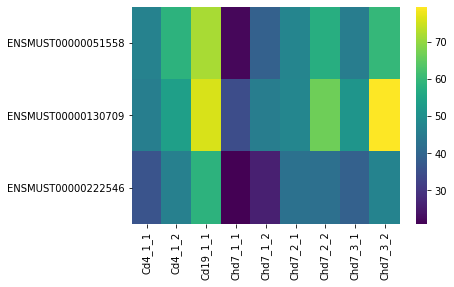

In [82]:
sns.heatmap(ts_tpm_sp_Chd7_df, cmap='viridis')

<AxesSubplot:>

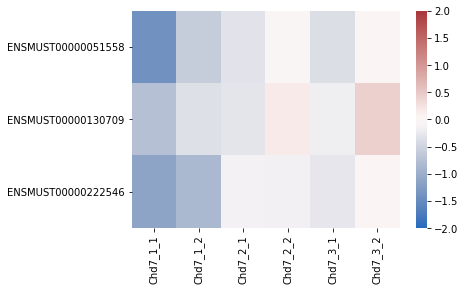

In [84]:
sns.heatmap(ts_tpm_sp_Chd7_df_RNAi_log2fc, vmin=-2, vmax=2, cmap='vlag')

In [8]:
fc_file = deseq2_compile_sep_dir + '/DESeq2_log2FoldChange.csv'
fc_df = pd.read_csv(fc_file, index_col=0).fillna(0)

cps = ['Chd7_1_vs_Ctrl', 'Chd7_2_vs_Ctrl', 'Chd7_3_vs_Ctrl']
fc_df = fc_df[cps]

In [32]:
Chd7RNAi_de_dir = root_dir + '/5_Chd7_shRNA_RNA/1_DEseq2'
conds = ['Chd7_1','Chd7_2', 'Chd7_3']
Chd7RNAi_v_ctrl_files = ["%s/%s_vs_Ctrl_gn.csv"%(Chd7RNAi_de_dir, i) for i in conds]
use_genes = slt_genes(Chd7RNAi_v_ctrl_files)
use_genes = [x for x in use_genes if not(x.startswith("Gm") or x.startswith("Rp"))]
len(use_genes)

['Chd7_1_vs_Ctrl_gn.csv', 'Chd7_2_vs_Ctrl_gn.csv', 'Chd7_3_vs_Ctrl_gn.csv']
395


371

## Clustermap

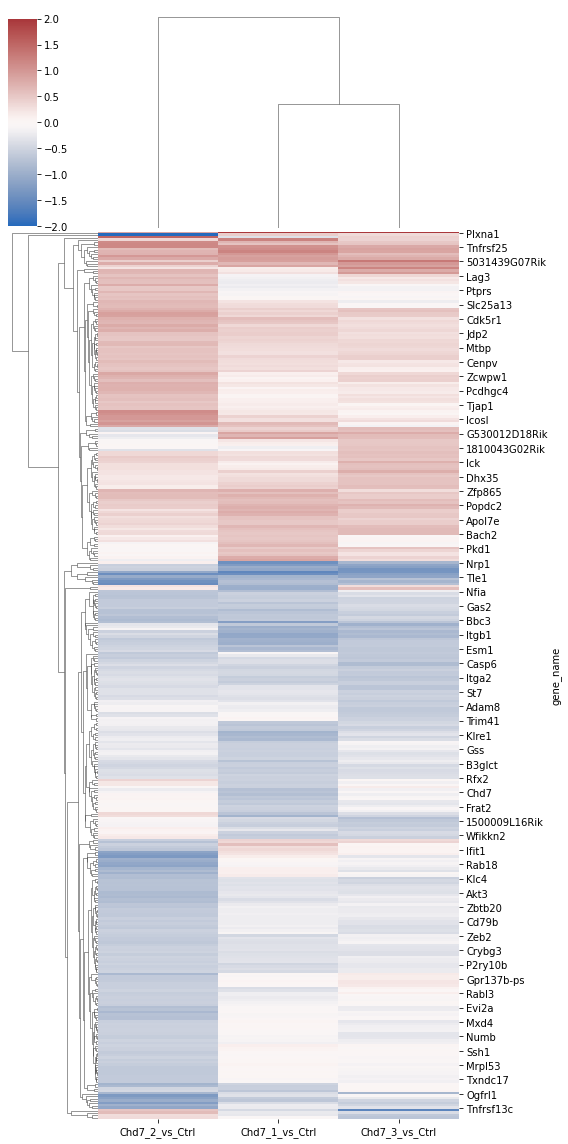

In [33]:
plot_out_dir = root_dir + '/9_Figures/5_Chd7_RNA_meta'
fc_df_use = fc_df.loc[[x for x in fc_df.index if x in use_genes]]

out_figure = "%s/Chd7RNAi_vs_WT_log2fc_heatmap.png"%plot_out_dir
out_csv = "%s/Chd7RNAi_vs_WT_log2fc_heatmap.csv"%plot_out_dir

hm = sns.clustermap(fc_df_use, cmap='vlag', vmin=-2, vmax=2, figsize=(8,16))
hm.savefig(out_figure)
plt.show()
plt.close()

# Without labels
hm = sns.clustermap(fc_df_use, cmap='vlag', vmin=-2, vmax=2, figsize=(8,16))
hm_ax = hm.ax_heatmap
hm_ax.set_xlabel("")
hm_ax.set_ylabel("")
hm_ax.set_xticklabels([])
hm_ax.set_yticklabels([])
hm.savefig(out_figure.replace(".png", "_noleg.png"))
plt.close()

hm_dgram = hm.dendrogram_row.dendrogram
hm_order = [fc_df_use.index.tolist()[int(x)] for x in hm_dgram['ivl']]
hm_order_df = fc_df_use.loc[hm_order]
hm_order_df.to_csv(out_csv)